<a href="https://colab.research.google.com/github/PercyMayaba/Credit-Risk-Modeling/blob/main/CreditRiskModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost imbalanced-learn plotly

print("Required packages installed successfully!")

Required packages installed successfully!


In [ ]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Cell 3: Generate synthetic loan dataset
np.random.seed(42)

def generate_synthetic_loan_data(n_samples=50000):
    """Generate synthetic loan data for credit risk modeling"""

    data = {
        'loan_id': range(1, n_samples + 1),
        'loan_type': np.random.choice(['Home Loan', 'Personal Loan', 'Credit Card', 'Auto Loan'],
                                     n_samples, p=[0.3, 0.3, 0.25, 0.15]),
        'loan_amount': np.random.lognormal(10, 1, n_samples),
        'interest_rate': np.random.normal(8, 3, n_samples),
        'term_months': np.random.choice([12, 24, 36, 48, 60, 120, 180, 240, 360], n_samples),
        'borrower_income': np.random.lognormal(10.5, 0.8, n_samples),
        'debt_to_income': np.random.beta(2, 5, n_samples) * 100,
        'credit_score': np.random.normal(680, 100, n_samples),
        'employment_length': np.random.exponential(5, n_samples),
        'age': np.random.randint(22, 70, n_samples),
        'number_open_accounts': np.random.poisson(8, n_samples),
        'credit_utilization': np.random.beta(2, 3, n_samples) * 100,
        'delinquency_2yrs': np.random.poisson(0.5, n_samples),
        'public_records': np.random.poisson(0.1, n_samples),
        'revolving_balance': np.random.lognormal(9, 1.5, n_samples),
        'total_debt': np.random.lognormal(10, 1, n_samples),
        'loan_to_value': np.random.beta(2, 2, n_samples) * 100,
        'property_value': np.random.lognormal(11, 1, n_samples)
    }

    df = pd.DataFrame(data)

    # Ensure realistic constraints
    df['interest_rate'] = np.clip(df['interest_rate'], 3, 25)
    df['credit_score'] = np.clip(df['credit_score'], 300, 850)
    df['debt_to_income'] = np.clip(df['debt_to_income'], 0, 60)
    df['employment_length'] = np.clip(df['employment_length'], 0, 40)

    # Generate default flag based on risk factors
    default_prob = (
        0.1 +
        0.3 * (df['credit_score'] < 600) +
        0.2 * (df['debt_to_income'] > 40) +
        0.15 * (df['delinquency_2yrs'] > 2) +
        0.1 * (df['employment_length'] < 2) +
        0.05 * (df['loan_amount'] / df['borrower_income'] > 5) +
        np.random.normal(0, 0.1, n_samples)
    )

    df['default_probability'] = np.clip(default_prob, 0, 1)
    df['default_flag'] = np.random.binomial(1, df['default_probability'])

    # Add EAD and LGD components
    df['ead'] = df['loan_amount'] * (0.8 + 0.2 * np.random.random(n_samples))
    df['lgd'] = np.random.beta(2, 3, n_samples)  # Loss Given Default

    # Calculate ECL
    df['ecl'] = df['default_probability'] * df['ead'] * df['lgd']

    return df

# Generate dataset
loan_df = generate_synthetic_loan_data(50000)
print("Synthetic loan dataset created!")
print(f"Dataset shape: {loan_df.shape}")
print("\nFirst few rows:")
loan_df.head()

Synthetic loan dataset created!
Dataset shape: (50000, 23)

First few rows:


,loan_id,loan_type,loan_amount,interest_rate,term_months,borrower_income,debt_to_income,credit_score,employment_length,age,...,public_records,revolving_balance,total_debt,loan_to_value,property_value,default_probability,default_flag,ead,lgd,ecl
0,1,Personal Loan,21610.543556,7.735053,12,18687.269203,20.956821,695.903893,3.020093,69,...,0,16326.054615,7526.866558,47.520794,84139.990033,0.096941,0,17660.705458,0.281528,481.990148
1,2,Auto Loan,73665.386325,12.510815,48,60585.763823,21.045949,620.651862,3.669247,24,...,0,1109.408681,44958.828522,55.014361,20272.547187,0.200739,0,63407.451266,0.496121,6314.789597
2,3,Credit Card,41162.891641,3.169957,240,24073.202170,24.800821,740.013037,1.274030,66,...,0,6002.894538,35936.774560,20.492548,379668.754566,0.193527,1,33863.612973,0.052584,344.610803
3,4,Personal Loan,9850.829674,8.584786,360,63713.486109,9.568722,807.244047,5.773985,51,...,0,597.637782,25199.829982,39.238403,10354.911979,0.080980,1,8579.475281,0.424448,294.891512
4,5,Home Loan,131546.202902,5.142274,180,38427.774070,9.064776,675.998604,17.934689,32,...,0,913.089594,8834.510179,67.262545,98548.730214,0.059465,0,121696.730892,0.434759,3146.196992


In [ ]:
# Cell 4: Dataset overview and basic statistics
print("=== DATASET OVERVIEW ===")
print(f"Total records: {len(loan_df)}")
print(f"Default rate: {loan_df['default_flag'].mean():.2%}")
print(f"Average ECL: ${loan_df['ecl'].mean():.2f}")

print("\n=== LOAN TYPE DISTRIBUTION ===")
print(loan_df['loan_type'].value_counts())

print("\n=== BASIC STATISTICS ===")
loan_df.describe()

=== DATASET OVERVIEW ===
Total records: 50000
Default rate: 25.50%
Average ECL: $3409.00

=== LOAN TYPE DISTRIBUTION ===
loan_type
Home Loan        15059
Personal Loan    14990
Credit Card      12494
Auto Loan         7457
Name: count, dtype: int64

=== BASIC STATISTICS ===


,loan_id,loan_amount,interest_rate,term_months,borrower_income,debt_to_income,credit_score,employment_length,age,number_open_accounts,...,public_records,revolving_balance,total_debt,loan_to_value,property_value,default_probability,default_flag,ead,lgd,ecl
count,50000.000000,5.000000e+04,50000.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,5.000000e+04,5.000000e+04,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,3.647476e+04,8.066312,120.11280,5.012699e+04,28.275025,677.991540,4.970251,45.464840,8.019640,...,0.098580,2.504083e+04,3.590245e+04,49.965806,9.895489e+04,0.252436,0.254960,32823.778836,0.399416,3409.001880
std,14433.901067,4.653064e+04,2.876043,111.83998,4.746808e+04,15.275110,96.334988,4.982602,13.898391,2.842502,...,0.313215,6.636872e+04,4.636041e+04,22.374877,1.316035e+05,0.181868,0.435843,42017.823071,0.199903,7145.791953
min,1.000000,2.539231e+02,3.000000,12.00000,1.014119e+03,0.097449,300.000000,0.000026,22.000000,0.000000,...,0.000000,1.422241e+01,4.317577e+02,0.218201,9.140917e+02,0.000000,0.000000,217.696384,0.001046,0.000000
25%,12500.750000,1.130971e+04,5.991433,36.00000,2.120462e+04,16.084029,611.825628,1.427109,33.000000,6.000000,...,0.000000,2.971612e+03,1.117255e+04,32.518611,3.057247e+04,0.109470,0.000000,10140.432106,0.242189,405.301122
50%,25000.500000,2.220536e+04,8.004051,60.00000,3.633723e+04,26.482716,679.431159,3.437394,45.000000,8.000000,...,0.000000,8.140924e+03,2.178514e+04,50.057481,5.962962e+04,0.223082,0.000000,19897.881838,0.386184,1308.530343
75%,37500.250000,4.349067e+04,10.024163,180.00000,6.239380e+04,38.882353,747.719654,6.882120,58.000000,10.000000,...,0.000000,2.242588e+04,4.291887e+04,67.291243,1.174373e+05,0.371385,1.000000,39153.815098,0.542908,3561.639083
max,50000.000000,1.014374e+06,20.606078,360.00000,1.091066e+06,60.000000,850.000000,40.000000,69.000000,23.000000,...,3.000000,2.915816e+06,1.625858e+06,99.676055,3.397817e+06,1.000000,1.000000,906004.847060,0.989045,253353.488833


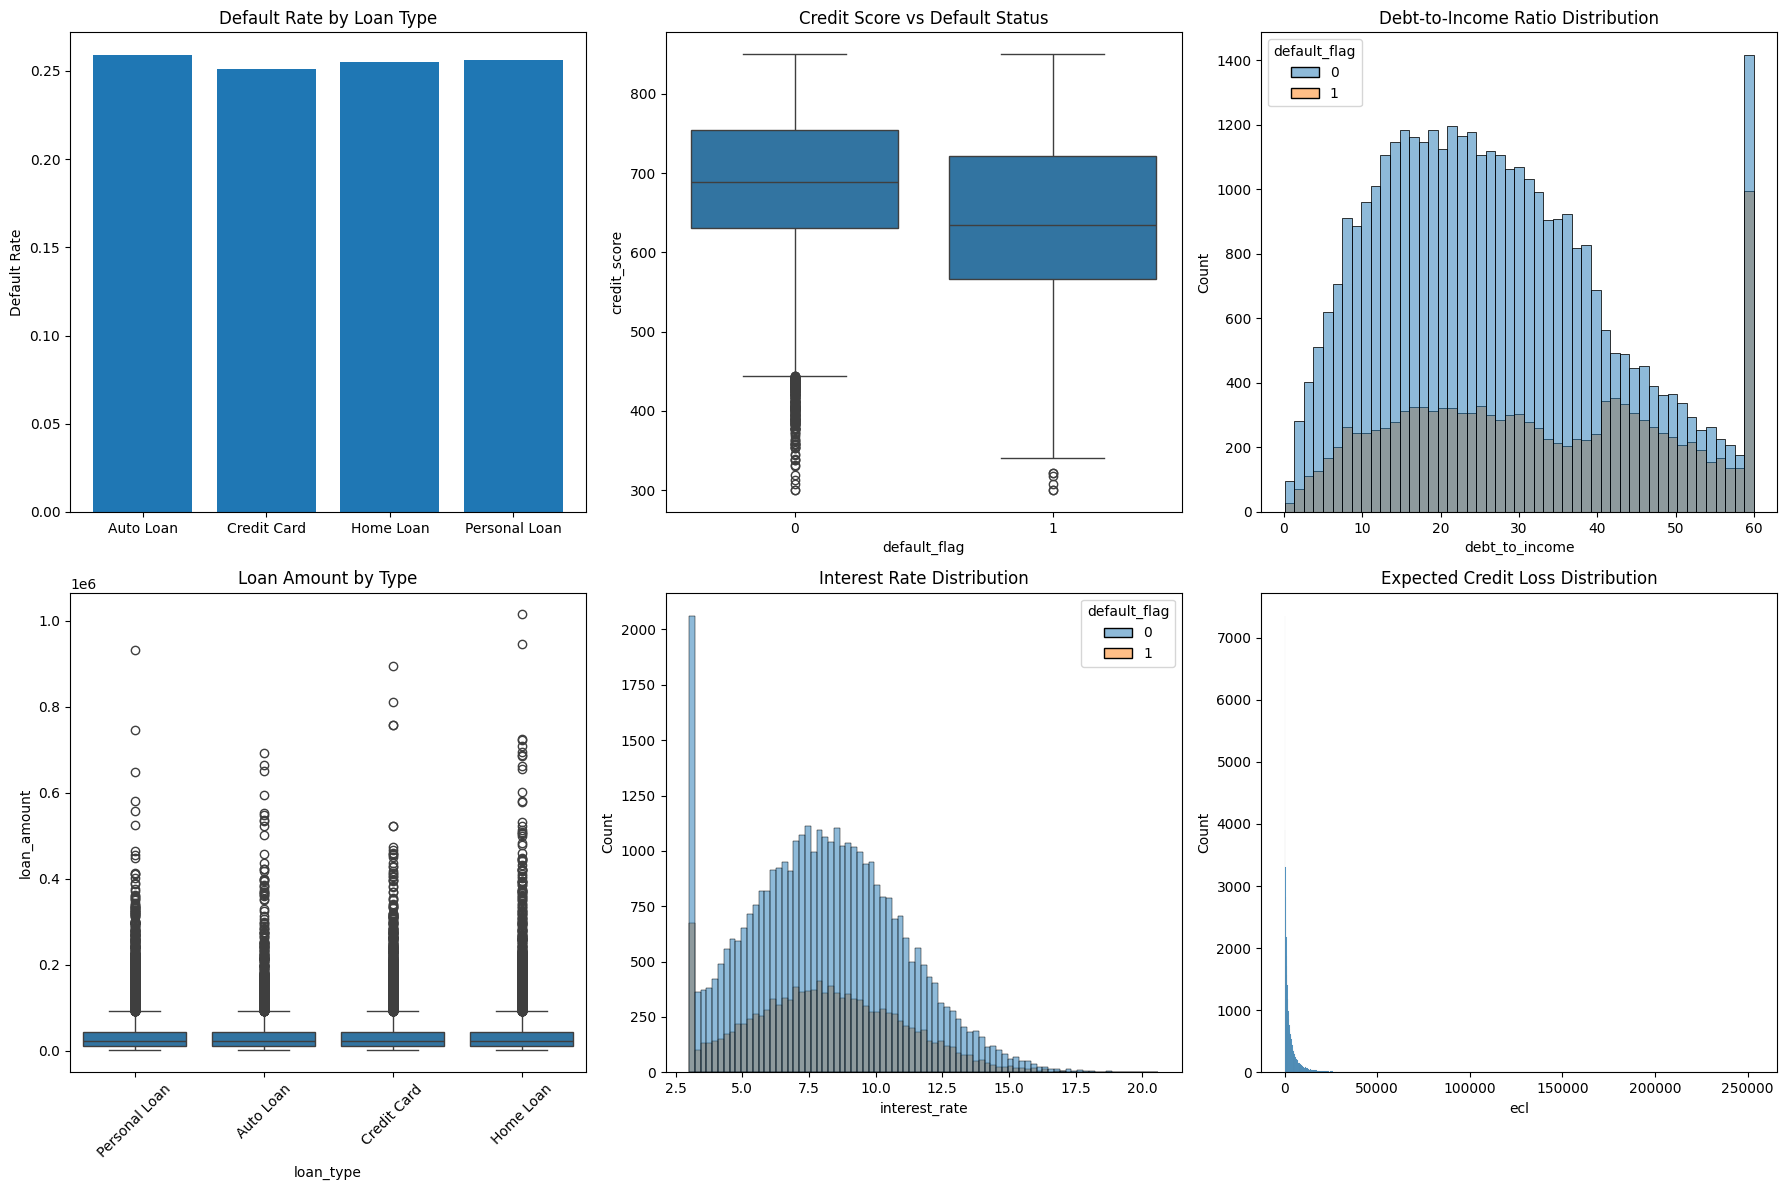

In [ ]:
# Cell 5: Exploratory Data Analysis - Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Default rate by loan type
default_by_type = loan_df.groupby('loan_type')['default_flag'].mean()
axes[0,0].bar(default_by_type.index, default_by_type.values)
axes[0,0].set_title('Default Rate by Loan Type')
axes[0,0].set_ylabel('Default Rate')

# Credit score distribution by default status
sns.boxplot(data=loan_df, x='default_flag', y='credit_score', ax=axes[0,1])
axes[0,1].set_title('Credit Score vs Default Status')

# Debt-to-income ratio
sns.histplot(data=loan_df, x='debt_to_income', hue='default_flag', ax=axes[0,2])
axes[0,2].set_title('Debt-to-Income Ratio Distribution')

# Loan amount distribution
sns.boxplot(data=loan_df, x='loan_type', y='loan_amount', ax=axes[1,0])
axes[1,0].set_title('Loan Amount by Type')
axes[1,0].tick_params(axis='x', rotation=45)

# Interest rates
sns.histplot(data=loan_df, x='interest_rate', hue='default_flag', ax=axes[1,1])
axes[1,1].set_title('Interest Rate Distribution')

# ECL distribution
sns.histplot(data=loan_df, x='ecl', ax=axes[1,2])
axes[1,2].set_title('Expected Credit Loss Distribution')

plt.tight_layout()
plt.show()

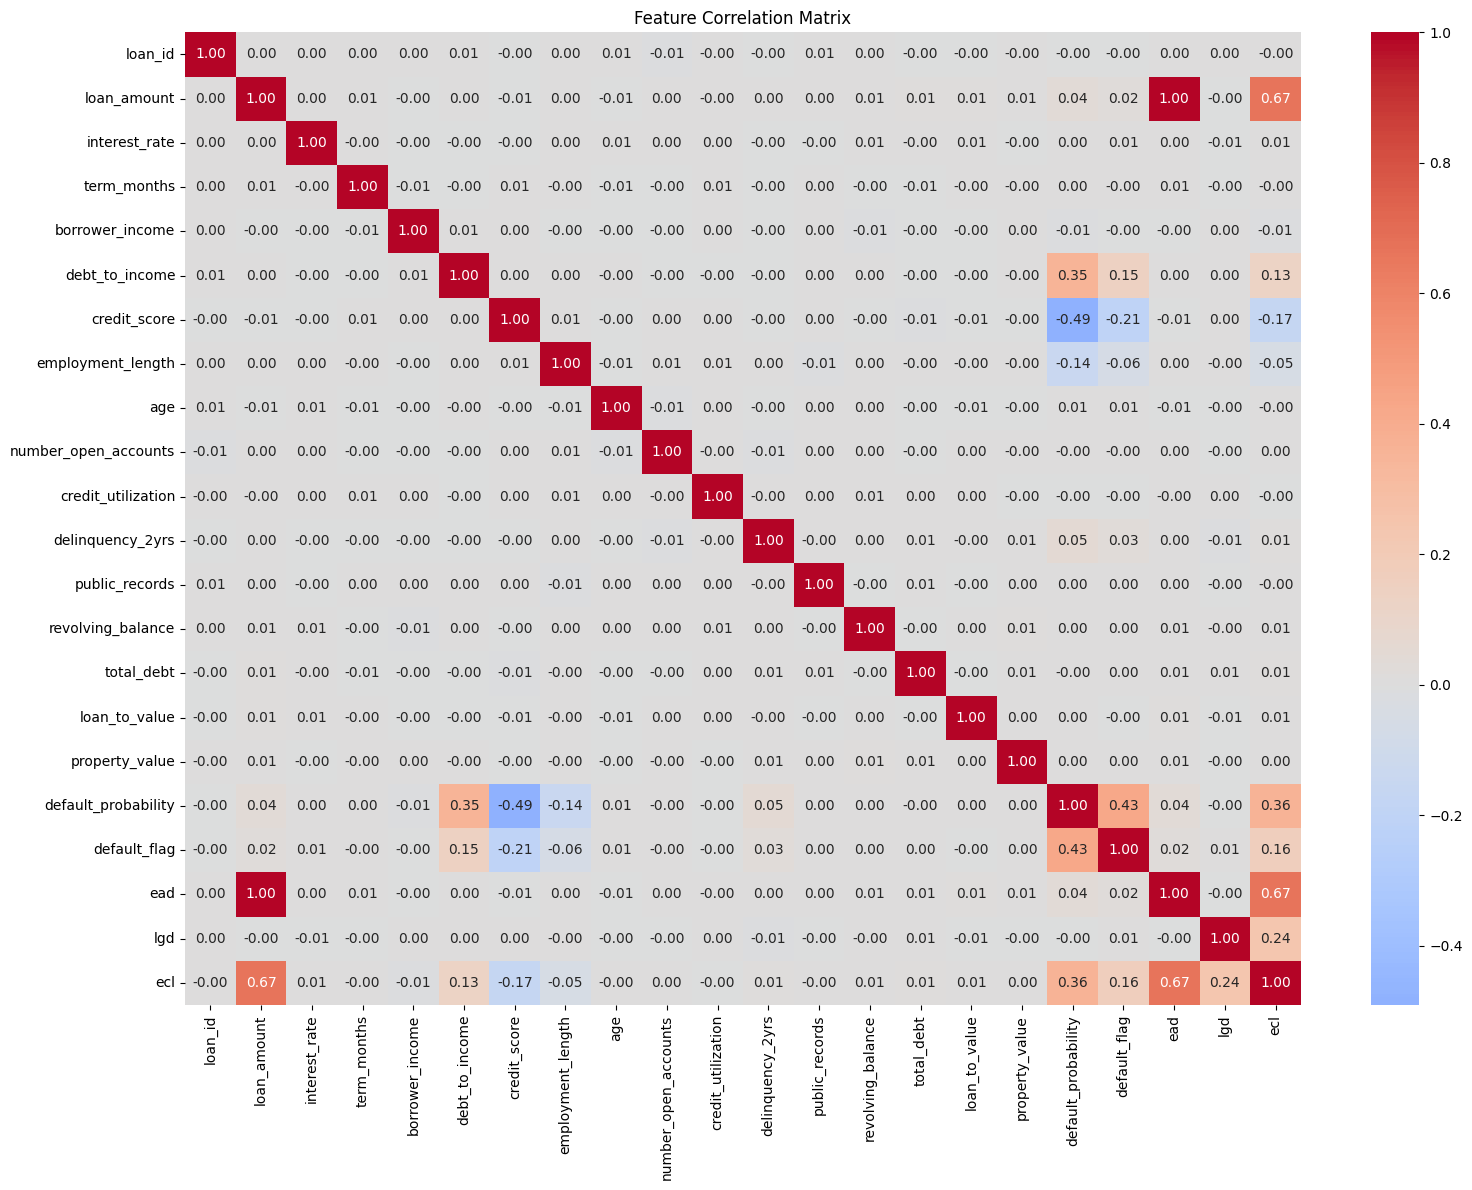

Top correlations with default flag:
default_flag           1.000000
default_probability    0.425760
ecl                    0.162860
debt_to_income         0.148454
delinquency_2yrs       0.027532
ead                    0.018258
loan_amount            0.017997
lgd                    0.009954
interest_rate          0.009850
age                    0.007651
Name: default_flag, dtype: float64


In [ ]:
# Cell 6: Correlation analysis
plt.figure(figsize=(16, 12))
correlation_matrix = loan_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Top correlations with default flag
default_correlations = correlation_matrix['default_flag'].sort_values(ascending=False)
print("Top correlations with default flag:")
print(default_correlations.head(10))

In [ ]:
# Cell 7: Feature engineering and preprocessing
# Create additional features
loan_df['income_to_loan_ratio'] = loan_df['borrower_income'] / loan_df['loan_amount']
loan_df['credit_age_ratio'] = loan_df['credit_score'] / loan_df['age']
loan_df['utilization_per_account'] = loan_df['credit_utilization'] / (loan_df['number_open_accounts'] + 1)

# Encode categorical variables
label_encoders = {}
categorical_columns = ['loan_type']

for col in categorical_columns:
    le = LabelEncoder()
    loan_df[f'{col}_encoded'] = le.fit_transform(loan_df[col])
    label_encoders[col] = le

# Select features for modeling
feature_columns = [
    'loan_amount', 'interest_rate', 'term_months', 'borrower_income',
    'debt_to_income', 'credit_score', 'employment_length', 'age',
    'number_open_accounts', 'credit_utilization', 'delinquency_2yrs',
    'public_records', 'revolving_balance', 'total_debt', 'loan_to_value',
    'income_to_loan_ratio', 'credit_age_ratio', 'utilization_per_account',
    'loan_type_encoded'
]

X = loan_df[feature_columns]
y = loan_df['default_flag']

print("Feature engineering completed!")
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Feature engineering completed!
Features shape: (50000, 19)
Target distribution:
default_flag
0    37252
1    12748
Name: count, dtype: int64


In [ ]:
# Cell 8: Handle class imbalance using SMOTE
print("Before SMOTE:")
print(f"Class distribution: {np.bincount(y)}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nAfter SMOTE:")
print(f"Class distribution: {np.bincount(y_resampled)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Before SMOTE:
Class distribution: [37252 12748]

After SMOTE:
Class distribution: [37252 37252]

Training set size: (59603, 19)
Test set size: (14901, 19)


In [ ]:
# Cell 9: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")

Feature scaling completed!


In [ ]:
# Cell 10: Build multiple models and compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'auc': roc_auc_score(y_test, y_pred_proba)
    }

    print(f"{name} - AUC: {results[name]['auc']:.4f}")
    print("-" * 50)

Training Logistic Regression...
Logistic Regression - AUC: 0.7140
--------------------------------------------------
Training Random Forest...
Random Forest - AUC: 0.8628
--------------------------------------------------
Training Gradient Boosting...
Gradient Boosting - AUC: 0.8751
--------------------------------------------------
Training XGBoost...
XGBoost - AUC: 0.8733
--------------------------------------------------


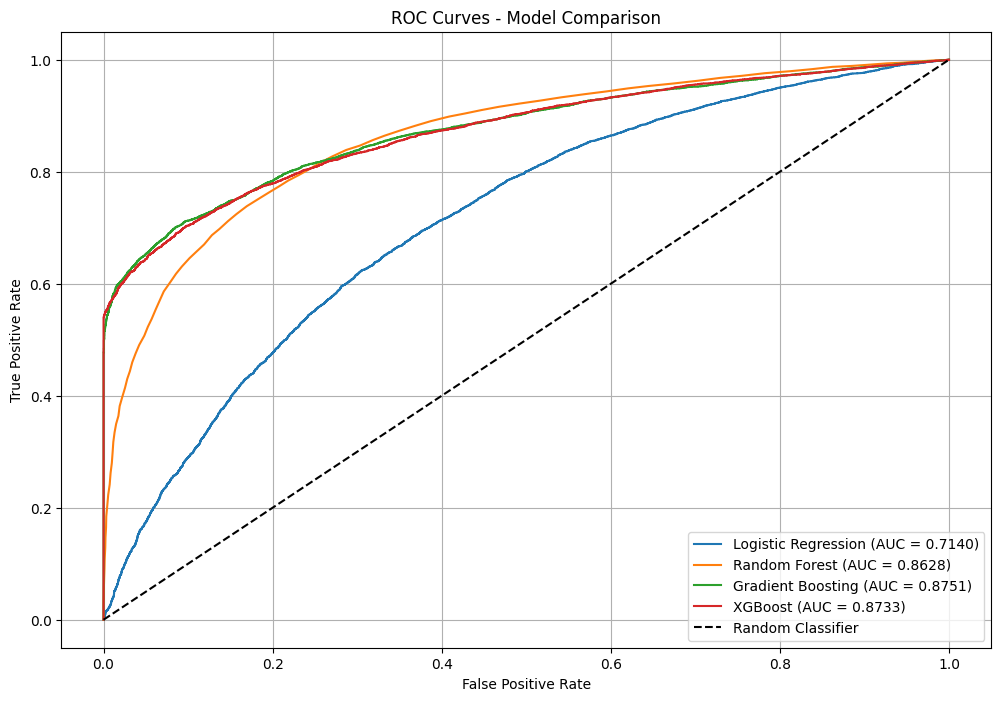

=== MODEL PERFORMANCE SUMMARY ===
Gradient Boosting: AUC = 0.8751
XGBoost: AUC = 0.8733
Random Forest: AUC = 0.8628
Logistic Regression: AUC = 0.7140


In [ ]:
# Cell 11: Model performance comparison
plt.figure(figsize=(12, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print AUC scores
print("=== MODEL PERFORMANCE SUMMARY ===")
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"{name}: AUC = {result['auc']:.4f}")

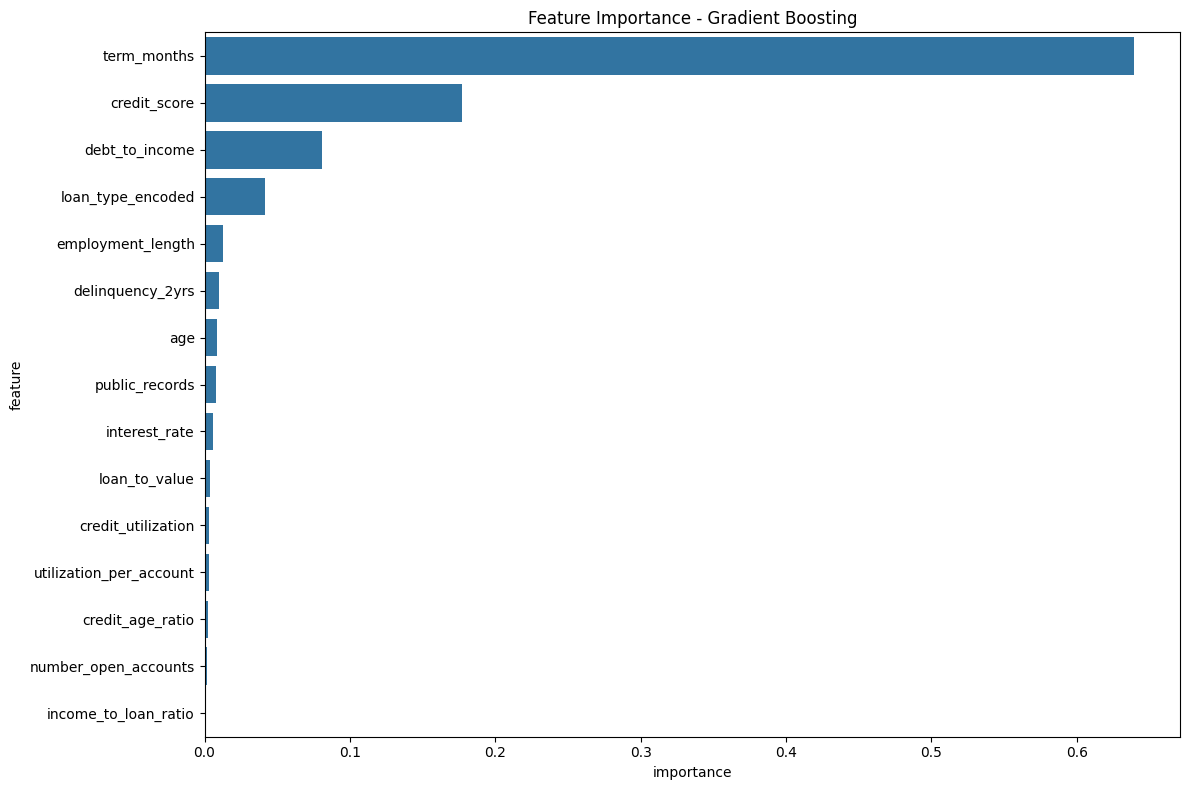

In [ ]:
# Cell 12: Feature importance from best model
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
best_model = results[best_model_name]['model']

plt.figure(figsize=(12, 8))

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    importances = best_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    sns.barplot(data=feature_imp_df.head(15), x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')

elif hasattr(best_model, 'coef_'):
    # Logistic Regression
    coefficients = best_model.coef_[0]
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': coefficients
    }).sort_values('coefficient', key=abs, ascending=False)

    sns.barplot(data=feature_imp_df.head(15), x='coefficient', y='feature')
    plt.title(f'Feature Coefficients - {best_model_name}')

plt.tight_layout()
plt.show()

Probability of Default (PD) calculated for all loans!
Average PD: 0.3473


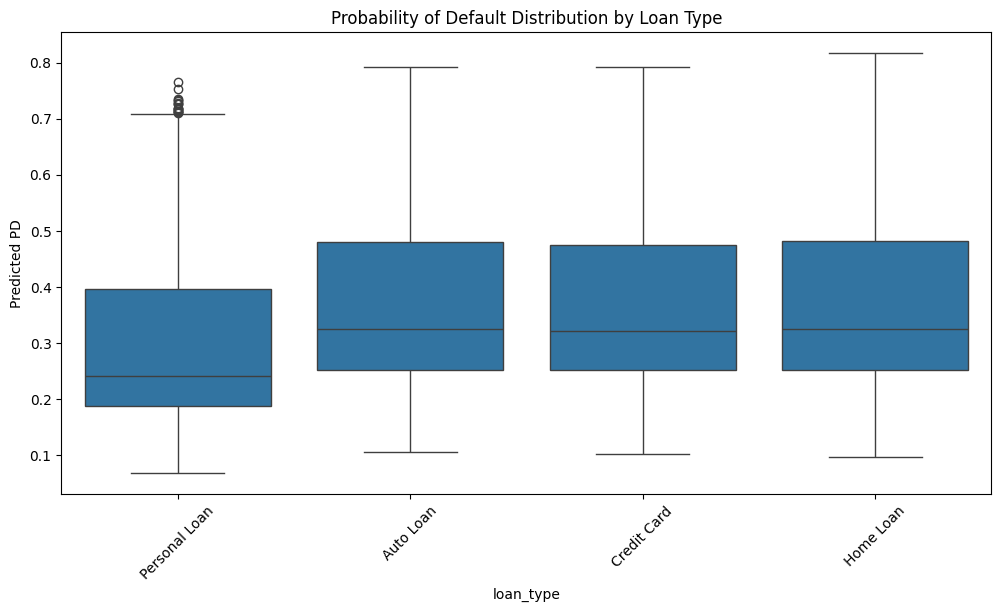

In [ ]:
# Cell 13: Probability of Default (PD) Modeling
# Use the best model to predict PD for all loans
if best_model_name == 'Logistic Regression':
    loan_df['pd_predicted'] = best_model.predict_proba(scaler.transform(X))[:, 1]
else:
    loan_df['pd_predicted'] = best_model.predict_proba(X)[:, 1]

print("Probability of Default (PD) calculated for all loans!")
print(f"Average PD: {loan_df['pd_predicted'].mean():.4f}")

# PD distribution by loan type
plt.figure(figsize=(12, 6))
sns.boxplot(data=loan_df, x='loan_type', y='pd_predicted')
plt.title('Probability of Default Distribution by Loan Type')
plt.ylabel('Predicted PD')
plt.xticks(rotation=45)
plt.show()

=== RISK RATING DISTRIBUTION ===
risk_rating
B          14881
BB          1396
BBB           33
CCC        17409
Default    16281
Name: count, dtype: int64


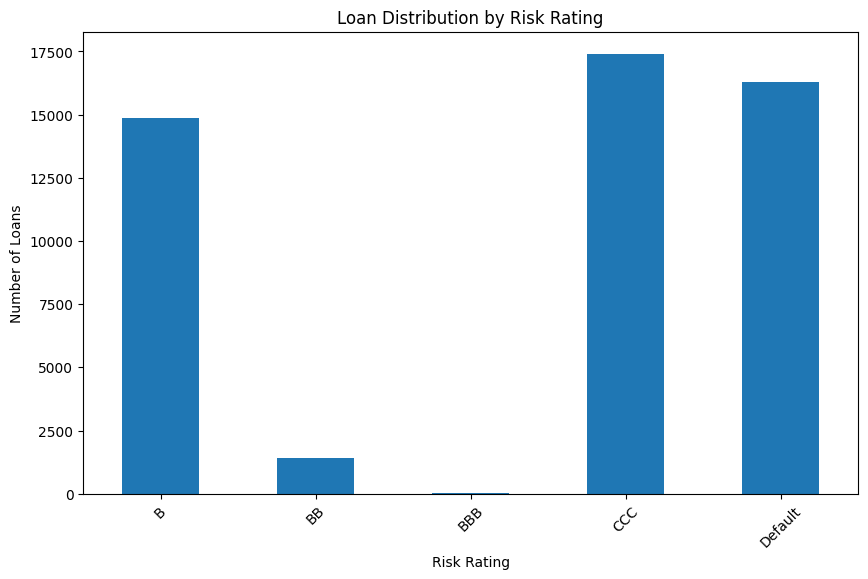

In [ ]:
# Cell 14: Credit Risk Buckets and Rating System
# Create risk buckets based on PD
def assign_risk_rating(pd):
    if pd <= 0.01:
        return 'AAA'
    elif pd <= 0.02:
        return 'AA'
    elif pd <= 0.05:
        return 'A'
    elif pd <= 0.1:
        return 'BBB'
    elif pd <= 0.15:
        return 'BB'
    elif pd <= 0.25:
        return 'B'
    elif pd <= 0.4:
        return 'CCC'
    else:
        return 'Default'

loan_df['risk_rating'] = loan_df['pd_predicted'].apply(assign_risk_rating)

# Display risk rating distribution
rating_distribution = loan_df['risk_rating'].value_counts().sort_index()
print("=== RISK RATING DISTRIBUTION ===")
print(rating_distribution)

plt.figure(figsize=(10, 6))
rating_distribution.plot(kind='bar')
plt.title('Loan Distribution by Risk Rating')
plt.xlabel('Risk Rating')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Cell 15: Expected Credit Loss (ECL) Calculation
# Calculate ECL using predicted PD
loan_df['ecl_predicted'] = loan_df['pd_predicted'] * loan_df['ead'] * loan_df['lgd']

print("=== EXPECTED CREDIT LOSS ANALYSIS ===")
print(f"Total Portfolio ECL: ${loan_df['ecl_predicted'].sum():,.2f}")
print(f"Average ECL per loan: ${loan_df['ecl_predicted'].mean():,.2f}")

# ECL by loan type
ecl_by_type = loan_df.groupby('loan_type')['ecl_predicted'].sum()
print(f"\nECL by Loan Type:")
for loan_type, ecl in ecl_by_type.items():
    print(f"{loan_type}: ${ecl:,.2f}")

# ECL by risk rating
ecl_by_rating = loan_df.groupby('risk_rating')['ecl_predicted'].sum()
print(f"\nECL by Risk Rating:")
for rating, ecl in ecl_by_rating.items():
    print(f"{rating}: ${ecl:,.2f}")

=== EXPECTED CREDIT LOSS ANALYSIS ===
Total Portfolio ECL: $229,188,403.65
Average ECL per loan: $4,583.77

ECL by Loan Type:
Auto Loan: $36,389,485.39
Credit Card: $59,944,781.40
Home Loan: $73,680,744.24
Personal Loan: $59,173,392.63

ECL by Risk Rating:
B: $39,261,071.86
BB: $2,183,439.77
BBB: $47,222.08
CCC: $71,493,899.05
Default: $116,202,770.89


In [ ]:
# Cell 16: Portfolio Risk Analysis
# Create risk analysis dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'ECL Distribution by Loan Type',
        'PD vs ECL Scatter',
        'Risk Rating Distribution',
        'Cumulative ECL by Risk Rating'
    ),
    specs=[[{"type": "bar"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# ECL by loan type
ecl_type = loan_df.groupby('loan_type')['ecl_predicted'].sum()
fig.add_trace(
    go.Bar(x=ecl_type.index, y=ecl_type.values, name='ECL by Type'),
    row=1, col=1
)

# PD vs ECL scatter
fig.add_trace(
    go.Scatter(x=loan_df['pd_predicted'], y=loan_df['ecl_predicted'],
               mode='markers', name='PD vs ECL', opacity=0.3),
    row=1, col=2
)

# Risk rating distribution
rating_counts = loan_df['risk_rating'].value_counts().sort_index()
fig.add_trace(
    go.Bar(x=rating_counts.index, y=rating_counts.values, name='Risk Ratings'),
    row=2, col=1
)

# Cumulative ECL by rating
cumulative_ecl = loan_df.groupby('risk_rating')['ecl_predicted'].sum().sort_index()
fig.add_trace(
    go.Bar(x=cumulative_ecl.index, y=cumulative_ecl.values, name='ECL by Rating'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Credit Risk Portfolio Dashboard")
fig.show()

In [ ]:
# Cell 17: Stress Testing and Scenario Analysis
def stress_test_scenarios(base_df, scenarios):
    """Perform stress testing under different economic scenarios"""
    results = {}

    for scenario_name, stress_factor in scenarios.items():
        # Apply stress to PD (increase by stress factor)
        stressed_pd = base_df['pd_predicted'] * stress_factor
        stressed_pd = np.clip(stressed_pd, 0, 1)

        # Calculate stressed ECL
        stressed_ecl = stressed_pd * base_df['ead'] * base_df['lgd']

        results[scenario_name] = {
            'total_ecl': stressed_ecl.sum(),
            'avg_pd': stressed_pd.mean(),
            'increase_pct': (stressed_ecl.sum() - base_df['ecl_predicted'].sum()) / base_df['ecl_predicted'].sum() * 100
        }

    return pd.DataFrame(results).T

# Define stress scenarios
scenarios = {
    'Baseline': 1.0,
    'Mild Recession': 1.5,
    'Severe Recession': 2.5,
    'Financial Crisis': 4.0
}

stress_results = stress_test_scenarios(loan_df, scenarios)
print("=== STRESS TESTING RESULTS ===")
print(stress_results)

=== STRESS TESTING RESULTS ===
                     total_ecl    avg_pd  increase_pct
Baseline          2.291884e+08  0.347255      0.000000
Mild Recession    3.422952e+08  0.518929     49.351014
Severe Recession  5.002356e+08  0.759920    118.263901
Financial Crisis  6.127703e+08  0.934444    167.365304


In [ ]:
# Cell 18: Capital Requirements Calculation (Simplified)
# Calculate regulatory capital based on Basel framework (simplified)
def calculate_regulatory_capital(loan_df):
    """Calculate simplified regulatory capital requirements"""

    # Risk weights (simplified)
    risk_weights = {
        'AAA': 0.2, 'AA': 0.3, 'A': 0.5,
        'BBB': 1.0, 'BB': 1.5, 'B': 2.0, 'CCC': 3.0, 'Default': 10.0
    }

    loan_df['risk_weight'] = loan_df['risk_rating'].map(risk_weights)
    loan_df['risk_weighted_assets'] = loan_df['loan_amount'] * loan_df['risk_weight']

    # Capital requirement (8% of RWA)
    loan_df['capital_requirement'] = loan_df['risk_weighted_assets'] * 0.08

    total_rwa = loan_df['risk_weighted_assets'].sum()
    total_capital = loan_df['capital_requirement'].sum()

    return total_rwa, total_capital

total_rwa, total_capital = calculate_regulatory_capital(loan_df)

print("=== CAPITAL REQUIREMENTS ===")
print(f"Total Risk Weighted Assets: ${total_rwa:,.2f}")
print(f"Total Regulatory Capital Required: ${total_capital:,.2f}")
print(f"Capital Ratio: {(total_capital / total_rwa * 100):.1f}%")

=== CAPITAL REQUIREMENTS ===
Total Risk Weighted Assets: $9,107,443,697.37
Total Regulatory Capital Required: $728,595,495.79
Capital Ratio: 8.0%


In [ ]:
# Cell 19: Model Validation and Backtesting
# Split data temporally for backtesting
loan_df['simulation_date'] = pd.date_range('2020-01-01', periods=len(loan_df), freq='D')

# Use first 80% for training, last 20% for validation
split_date = loan_df['simulation_date'].quantile(0.8)
train_mask = loan_df['simulation_date'] <= split_date
test_mask = loan_df['simulation_date'] > split_date

# Calculate actual vs predicted defaults in validation period
actual_defaults_val = loan_df.loc[test_mask, 'default_flag'].sum()
predicted_defaults_val = loan_df.loc[test_mask, 'pd_predicted'].sum()

print("=== MODEL VALIDATION RESULTS ===")
print(f"Validation Period: {split_date.date()} to {loan_df['simulation_date'].max().date()}")
print(f"Actual defaults in validation period: {actual_defaults_val}")
print(f"Predicted defaults in validation period: {predicted_defaults_val:.2f}")
print(f"Prediction accuracy: {(1 - abs(actual_defaults_val - predicted_defaults_val) / actual_defaults_val) * 100:.2f}%")

# Calculate calibration metrics
calibration_data = loan_df[test_mask].copy()
calibration_data['pd_bucket'] = pd.cut(calibration_data['pd_predicted'], bins=10)
calibration_stats = calibration_data.groupby('pd_bucket').agg({
    'pd_predicted': 'mean',
    'default_flag': 'mean',
    'loan_id': 'count'
}).reset_index()

print("\n=== MODEL CALIBRATION ===")
print(calibration_stats[['pd_bucket', 'pd_predicted', 'default_flag', 'loan_id']])

=== MODEL VALIDATION RESULTS ===
Validation Period: 2129-07-07 to 2156-11-22
Actual defaults in validation period: 2559
Predicted defaults in validation period: 3477.97
Prediction accuracy: 64.09%

=== MODEL CALIBRATION ===
         pd_bucket  pd_predicted  default_flag  loan_id
0  (0.0776, 0.149]      0.132798      0.088652      282
1    (0.149, 0.22]      0.189020      0.108978     1927
2    (0.22, 0.291]      0.253993      0.156436     2346
3   (0.291, 0.362]      0.322589      0.187117     1630
4   (0.362, 0.432]      0.396019      0.302227      943
5   (0.432, 0.503]      0.468131      0.406067     1022
6   (0.503, 0.574]      0.536327      0.458234      838
7   (0.574, 0.645]      0.606293      0.503546      564
8   (0.645, 0.716]      0.676385      0.602484      322
9   (0.716, 0.787]      0.742312      0.714286      126


In [ ]:
# Cell 20: Comprehensive Risk Report
print("="*60)
print("COMPREHENSIVE CREDIT RISK MODELING REPORT")
print("="*60)

print(f"\nPORTFOLIO SUMMARY:")
print(f"Total Loans: {len(loan_df):,}")
print(f"Total Portfolio Value: ${loan_df['loan_amount'].sum():,.2f}")
print(f"Average Loan Size: ${loan_df['loan_amount'].mean():,.2f}")

print(f"\nCREDIT RISK METRICS:")
print(f"Overall Default Rate: {loan_df['default_flag'].mean():.2%}")
print(f"Average Predicted PD: {loan_df['pd_predicted'].mean():.2%}")
print(f"Total Expected Credit Loss: ${loan_df['ecl_predicted'].sum():,.2f}")
print(f"ECL as % of Portfolio: {(loan_df['ecl_predicted'].sum() / loan_df['loan_amount'].sum() * 100):.2f}%")

print(f"\nMODEL PERFORMANCE:")
print(f"Best Model: {best_model_name}")
print(f"Validation AUC: {results[best_model_name]['auc']:.4f}")

print(f"\nCAPITAL & REGULATORY:")
total_rwa, total_capital = calculate_regulatory_capital(loan_df)
print(f"Risk Weighted Assets: ${total_rwa:,.2f}")
print(f"Regulatory Capital: ${total_capital:,.2f}")

print(f"\nRISK CONCENTRATION:")
highest_risk_loans = loan_df.nlargest(5, 'ecl_predicted')[['loan_id', 'loan_type', 'pd_predicted', 'ecl_predicted']]
print("Top 5 Highest Risk Loans:")
print(highest_risk_loans.to_string(index=False))

print(f"\nRECOMMENDATIONS:")
print("1. Monitor high-risk loans in CCC and Default buckets")
print("2. Consider increasing provisions for personal and credit card loans")
print("3. Review underwriting criteria for high-PD segments")
print("4. Ensure adequate capital coverage for stressed scenarios")

COMPREHENSIVE CREDIT RISK MODELING REPORT

PORTFOLIO SUMMARY:
Total Loans: 50,000
Total Portfolio Value: $1,823,738,153.46
Average Loan Size: $36,474.76

CREDIT RISK METRICS:
Overall Default Rate: 25.50%
Average Predicted PD: 34.73%
Total Expected Credit Loss: $229,188,403.65
ECL as % of Portfolio: 12.57%

MODEL PERFORMANCE:
Best Model: Gradient Boosting
Validation AUC: 0.8751

CAPITAL & REGULATORY:
Risk Weighted Assets: $9,107,443,697.37
Regulatory Capital: $728,595,495.79

RISK CONCENTRATION:
Top 5 Highest Risk Loans:
 loan_id     loan_type  pd_predicted  ecl_predicted
   49970 Personal Loan      0.577271  295666.702407
   15544   Credit Card      0.750026  247386.465424
   27589     Auto Loan      0.644092  236007.849340
   32354     Home Loan      0.740963  205489.787963
   47718   Credit Card      0.525147  192677.397259

RECOMMENDATIONS:
1. Monitor high-risk loans in CCC and Default buckets
2. Consider increasing provisions for personal and credit card loans
3. Review underwritin